# Bayesian Regression

Regression is one of the most common and basic supervised learning tasks in machine learning. Suppose we're given a dataset $\mathcal{D}$ of the form

$$ \mathcal{D}  = \{ (X_i, y_i) \} \qquad \text{for}\qquad i=1,2,...,N$$

The goal of linear regression is to fit a function to the data of the form:

$$ y = w X + b + \epsilon $$

where $w$ and $b$ are learnable parameters and $\epsilon$ represents observation noise. Specifically $w$ is a matrix of weights and $b$ is a bias vector.

In this tutorial, we will first implement linear regression in PyTorch and learn point estimates for the parameters $w$ and $b$.  Then we will see how to incorporate uncertainty into our estimates by using Pyro to implement Bayesian regression.

## Tutorial Outline

 - [Setup](#Setup)
   - [Dataset](#Dataset)
 - [Linear Regression](#Linear-Regression)
   - [Training with PyTorch Optimizers](#Training-with-PyTorch-Optimizers)
   - [Regression Fit](#Plotting-the-Regression-Fit)
 - [Bayesian Regression with Pyro's SVI](#Bayesian-Regression-with-Pyro's-Stochastic-Variational-Inference-%28SVI%29)
   - [Model](#Model)
   - [Using an AutoGuide](#Using-an-AutoGuide)
   - [Optimizing the Evidence Lower Bound](#Optimizing-the-Evidence-Lower-Bound)
 - [Model Evaluation](#Model-Evaluation)
 - [Serving the Model using TorchScript](#Model-Serving-via-TorchScript)

## Setup
Let's begin by importing the modules we'll need.

In [1]:
%reset -s -f

In [2]:
import os
from functools import partial
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import pyro
import pyro.distributions as dist

# for CI testing
smoke_test = ('CI' in os.environ)
assert pyro.__version__.startswith('1.4.0')
pyro.enable_validation(True)
pyro.set_rng_seed(1)
pyro.enable_validation(True)


# Set matplotlib settings
%matplotlib inline
plt.style.use('default')

### Dataset 

The following example is adapted from \[1\].  We would like to explore the relationship between topographic heterogeneity of a nation as measured by the Terrain Ruggedness Index (variable *rugged* in the dataset) and its GDP per capita. In particular, it was noted by the authors in \[2\] that terrain ruggedness or bad geography is related to poorer economic performance outside of Africa, but rugged terrains have had a reverse effect on income for African nations. Let us look at the data and investigate this relationship.  We will be focusing on three features from the dataset:
  - `rugged`: quantifies the Terrain Ruggedness Index
  - `cont_africa`: whether the given nation is in Africa
  - `rgdppc_2000`: Real GDP per capita for the year 2000
  
The response variable GDP is highly skewed, so we will log-transform it.

In [3]:
DATA_URL = "https://d2hg8soec8ck9v.cloudfront.net/datasets/rugged_data.csv"
data = pd.read_csv(DATA_URL, encoding="ISO-8859-1")
df = data[["cont_africa", "rugged", "rgdppc_2000"]]
df = df[np.isfinite(df.rgdppc_2000)]
df["rgdppc_2000"] = np.log(df["rgdppc_2000"])

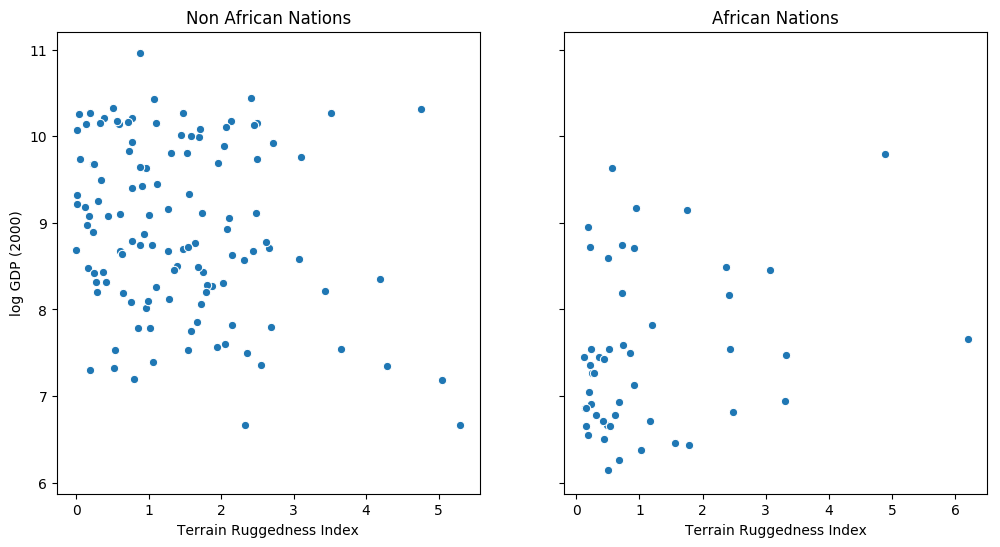

In [4]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), sharey=True)
african_nations = df[df["cont_africa"] == 1]
non_african_nations = df[df["cont_africa"] == 0]
sns.scatterplot(non_african_nations["rugged"], 
            non_african_nations["rgdppc_2000"], 
            ax=ax[0])
ax[0].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="Non African Nations")
sns.scatterplot(african_nations["rugged"], 
                african_nations["rgdppc_2000"], 
                ax=ax[1])
ax[1].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="African Nations");

## Bayesian Regression with Pyro's Stochastic Variational Inference (SVI)

In [ ]:
def linear_reg_model(a, b_a, b_r, b_ar, is_cont_africa, ruggedness):
    return a + b_a * is_cont_africa + b_r * ruggedness + b_ar * is_cont_africa * ruggedness

def mse_loss(y_pred, y_true):
    return -torch.sum((y_pred - y_true) ** 2)

### Model

In order to make our linear regression Bayesian, we need to put priors on the parameters $w$ and $b$. These are distributions that represent our prior belief about reasonable values for $w$ and $b$ (before observing any data).

Making a Bayesian model for linear regression is very intuitive using Pyro.

In [ ]:
def model(is_cont_africa, ruggedness, log_gdp=None):
    a = pyro.sample("a", dist.Normal(0., 10.))
    b_a = pyro.sample("bA", dist.Normal(0., 1.))
    b_r = pyro.sample("bR", dist.Normal(0., 1.))
    b_ar = pyro.sample("bAR", dist.Normal(0., 1.))
    sigma = pyro.sample("sigma", dist.Uniform(0., 10.))
    mean = a + b_a * is_cont_africa + b_r * ruggedness + b_ar * is_cont_africa * ruggedness
    with pyro.plate("data", len(ruggedness)):
        obs = pyro.sample("obs", dist.Normal(mean, sigma), obs=log_gdp)
        return mean

### Writing a guide

In order to do inference, i.e. learn the posterior distribution over our unobserved parameters, we will use Stochastic Variational Inference (SVI). The guide determines a family of distributions, and `SVI` aims to find an approximate posterior distribution from this family that has the lowest KL divergence from the true posterior. 

To begin with, we will use a guide that models the distribution of unobserved parameters in the model as a Gaussian with diagonal covariance, i.e. it assumes that there is no correlation amongst the latent variables (quite a strong modeling assumption as we shall see).

In [ ]:
def hand_guide(is_cont_africa, ruggedness, log_gdp=None):
    a_loc = pyro.param('a_loc', torch.tensor(0.))
    a_scale = pyro.param('a_scale', torch.tensor(1.),
                         constraint=constraints.positive)
    sigma_loc = pyro.param('sigma_loc', torch.tensor(1.),
                             constraint=constraints.positive)
    weights_loc = pyro.param('weights_loc', torch.randn(3))
    weights_scale = pyro.param('weights_scale', torch.ones(3),
                               constraint=constraints.positive)
    a = pyro.sample("a", dist.Normal(a_loc, a_scale))
    b_a = pyro.sample("bA", dist.Normal(weights_loc[0], weights_scale[0]))
    b_r = pyro.sample("bR", dist.Normal(weights_loc[1], weights_scale[1]))
    b_ar = pyro.sample("bAR", dist.Normal(weights_loc[2], weights_scale[2]))
    sigma = pyro.sample("sigma", dist.Normal(sigma_loc, torch.tensor(0.05)))

### Using an Autoguide

Writing guides by hand can be tedious, especially when making standard simplifying assumptions. Pyro's [autoguide library](http://docs.pyro.ai/en/dev/infer.autoguide.html) provides a small set of ready-made guides that often work reasonably well as first attempts at inference. Autoguide also supports learning MAP estimates with `AutoDelta` or composing guides with `AutoGuideList` (see the [docs](http://docs.pyro.ai/en/dev/infer.autoguide.html) for more information).

In [9]:
from pyro.infer.autoguide import AutoDiagonalNormal, AutoMultivariateNormal, init_to_mean

# equivalent to handwritten guide; ignores posterior correlations
autodiag_guide = AutoDiagonalNormal(model)

# models the correlations between all latent variables in the posterior distribution
automvn_guide = AutoMultivariateNormal(model, init_fn=init_to_mean)

### Optimizing the Evidence Lower Bound (ELBO)

We will use stochastic variational inference (SVI) (for an introduction to SVI, see [SVI Part I](svi_part_i.ipynb)) for doing inference. Just like in the non-Bayesian linear regression model, each iteration of our training loop will take a gradient step, with the difference that in this case, we'll use the Evidence Lower Bound (ELBO) objective instead of the MSE loss by constructing a `Trace_ELBO` object that we pass to `SVI`. 

In [10]:
from pyro.infer import SVI, Trace_ELBO

adam = pyro.optim.Adam({"lr": 0.03})
svi = SVI(model, autodiag_guide, adam, loss=Trace_ELBO())

Note that we use the `Adam` optimizer from Pyro's `optim` module and not the `torch.optim` module as earlier. Here `Adam` is a thin wrapper around `torch.optim.Adam` (see [here](svi_part_i.ipynb#Optimizers) for a discussion). Optimizers in `pyro.optim` are used to optimize and update parameter values in Pyro's parameter store. In particular, you will notice that we do not need to pass in learnable parameters to the optimizer since that is determined by the guide code and happens behind the scenes within the `SVI` class automatically. To take an ELBO gradient step we simply call the step method of SVI. The data argument we pass to `SVI.step` will be passed to both `model()` and `guide()`. The complete training loop is as follows:

In [11]:
pyro.clear_param_store()
num_iters = 5000
for i in range(num_iters):
    elbo = svi.step(is_cont_africa, ruggedness, log_gdp)
    if i % 500 == 0:
        logging.info("Elbo loss: {}".format(elbo))

[iteration 0001] loss: 6.2310
[iteration 0101] loss: 3.5253
[iteration 0201] loss: 3.2347
[iteration 0301] loss: 3.0890
[iteration 0401] loss: 2.6377
[iteration 0501] loss: 2.0626
[iteration 0601] loss: 1.4852
[iteration 0701] loss: 1.4631
[iteration 0801] loss: 1.4632
[iteration 0901] loss: 1.4592
[iteration 1001] loss: 1.4940
[iteration 1101] loss: 1.4988
[iteration 1201] loss: 1.4938
[iteration 1301] loss: 1.4679
[iteration 1401] loss: 1.4581


We can examine the optimized parameter values by fetching from Pyro's param store.

In [12]:
for name, value in pyro.get_param_store().items():
    print(name, pyro.param(name))

AutoDiagonalNormal.loc Parameter containing:
tensor([-2.2371, -1.8097, -0.1691,  0.3791,  9.1823])
AutoDiagonalNormal.scale tensor([0.0551, 0.1142, 0.0387, 0.0769, 0.0702])


## Model Evaluation

To evaluate our model, we'll generate some predictive samples and look at the posteriors. For this we will make use of the [Predictive](http://docs.pyro.ai/en/stable/inference_algos.html#pyro.infer.predictive.Predictive) utility class.

  - We generate 800 samples from our trained model. Internally, this is done by first generating samples for the unobserved sites in the `guide`, and then running the model forward by conditioning the sites to values sampled from the `guide`.
  - Note that in `return_sites`, we specify both the outcome (`"obs"` site) as well as the return value of the model (`"_RETURN"`) which captures the regression line. Additionally, we would also like to capture the regression coefficients (given by `"linear.weight"`) for further analysis.
  - The remaining code is simply used to plot the 90% CI for the two variables from our model.

In [14]:
from pyro.infer import Predictive


def summary(samples):
    site_stats = {}
    for k, v in samples.items():
        site_stats[k] = {
            "mean": torch.mean(v, 0),
            "std": torch.std(v, 0),
            "5%": v.kthvalue(int(len(v) * 0.05), dim=0)[0],
            "95%": v.kthvalue(int(len(v) * 0.95), dim=0)[0],
        }
    return site_stats


predictive = Predictive(model, guide=guide, num_samples=800, 
                        return_sites=("a", "b_a", "b_r", "b_ar", "obs"))
samples = predictive(x_data)
pred_summary = summary(samples)

In [15]:
y = pred_summary["obs"]
predictions = pd.DataFrame({
    "cont_africa": x_data[:, 0],
    "rugged": x_data[:, 1],
    "y_mean": y["mean"],
    "y_perc_5": y["5%"],
    "y_perc_95": y["95%"],
    "true_gdp": y_data,
})

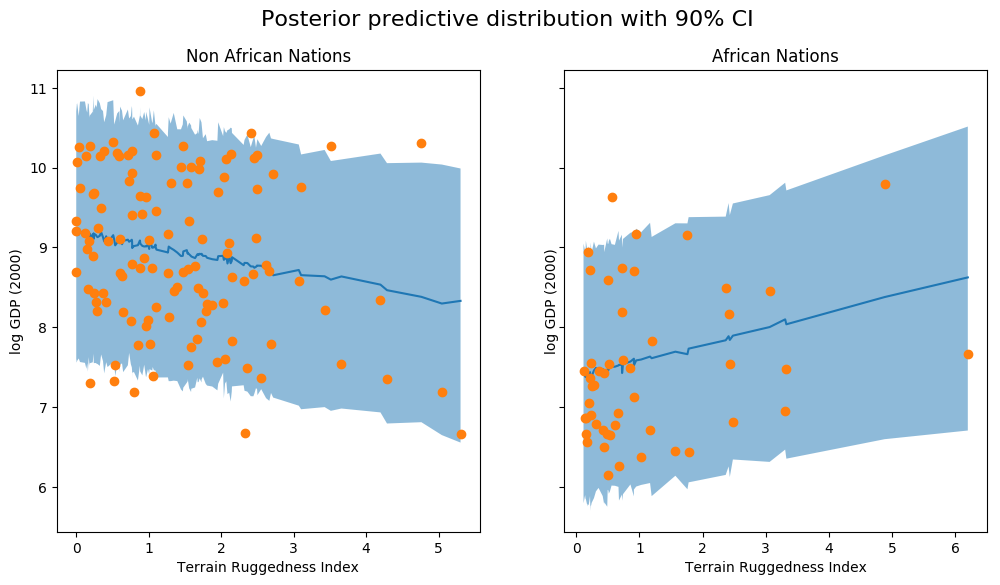

In [17]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), sharey=True)
fig.suptitle("Posterior predictive distribution with 90% CI", fontsize=16)
ax[0].plot(non_african_nations["rugged"], 
           non_african_nations["y_mean"])
ax[0].fill_between(non_african_nations["rugged"], 
                   non_african_nations["y_perc_5"],
                   non_african_nations["y_perc_95"],
                   alpha=0.5)
ax[0].plot(non_african_nations["rugged"], 
           non_african_nations["true_gdp"],
           "o")
ax[0].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="Non African Nations")
idx = np.argsort(african_nations["rugged"])

ax[1].plot(african_nations["rugged"], 
           african_nations["y_mean"])
ax[1].fill_between(african_nations["rugged"],
                   african_nations["y_perc_5"],
                   african_nations["y_perc_95"],
                   alpha=0.5)
ax[1].plot(african_nations["rugged"], 
           african_nations["true_gdp"],
           "o")
ax[1].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="African Nations");

We observe that the outcome from our model and the 90% CI accounts for the majority of the data points that we observe in practice. It is usually a good idea to do such posterior predictive checks to see if our model gives valid predictions. 

Finally, let us revisit our earlier question of how robust the relationship between terrain ruggedness and GDP is against any uncertainty in the parameter estimates from our model. For this, we plot the distribution of the slope of the log GDP given terrain ruggedness for nations within and outside Africa. As can be seen below, the probability mass for African nations is largely concentrated in the positive region and vice-versa for other nations, lending further credence to the original hypothesis. 

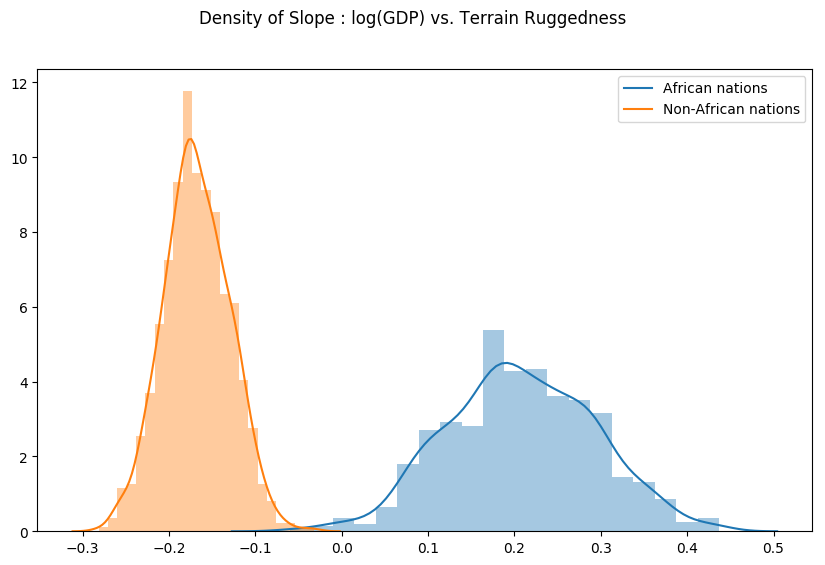

In [18]:
weight = samples["linear.weight"]
weight = weight.reshape(weight.shape[0], 3)
gamma_within_africa = weight[:, 1] + weight[:, 2]
gamma_outside_africa = weight[:, 1]
fig = plt.figure(figsize=(10, 6))
sns.distplot(gamma_within_africa, kde_kws={"label": "African nations"},)
sns.distplot(gamma_outside_africa, kde_kws={"label": "Non-African nations"})
fig.suptitle("Density of Slope : log(GDP) vs. Terrain Ruggedness");

## MultivariateNormal Guide

As comparison to the previously obtained results from Diagonal Normal guide, we will now use a guide that generates samples from a Cholesky factorization of a multivariate normal distribution.  This allows us to capture the correlations between the latent variables via a covariance matrix.  If we wrote this manually, we would need to combine all the latent variables so we could sample a Multivarite Normal jointly.

In [ ]:
guide = AutoMultivariateNormal(model, init_loc_fn=init_to_mean)

svi = SVI(model, 
          guide, 
          optim.Adam({"lr": .01}), 
          loss=Trace_ELBO())

is_cont_africa, ruggedness, log_gdp = train[:, 0], train[:, 1], train[:, 2]
pyro.clear_param_store()
for i in range(num_iters):
    elbo = svi.step(is_cont_africa, ruggedness, log_gdp)
    if i % 500 == 0:
        logging.info("Elbo loss: {}".format(elbo))

Now let's compare the posterior computed by the Diagonal Normal guide vs the Multivariate Normal guide.  Note that the multivariate normal approximation is more dispersed than the diagonal approximation.

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
fig.suptitle("Cross-sections of the Posterior Distribution", fontsize=16)
sns.kdeplot(svi_samples["bA"], svi_samples["bR"], ax=axs[0], label="SVI (Diagonal Normal)")
sns.kdeplot(svi_mvn_samples["bA"], svi_mvn_samples["bR"], ax=axs[0], shade=True, label="SVI (Multivariate Normal)")
axs[0].set(xlabel="bA", ylabel="bR", xlim=(-2.5, -1.2), ylim=(-0.5, 0.1))
sns.kdeplot(svi_samples["bR"], svi_samples["bAR"], ax=axs[1], label="SVI (Diagonal Normal)")
sns.kdeplot(svi_mvn_samples["bR"], svi_mvn_samples["bAR"], ax=axs[1], shade=True, label="SVI (Multivariate Normal)")
axs[1].set(xlabel="bR", ylabel="bAR", xlim=(-0.45, 0.05), ylim=(-0.15, 0.8))
handles, labels = axs[1].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right');

# Variational Autoencoders

## Introduction

The variational autoencoder (VAE) is arguably the simplest setup that realizes deep probabilistic modeling. Note that we're being careful in our choice of language here. The VAE isn't a model as such&mdash;rather the VAE is a particular setup for doing variational inference for a certain class of models. The class of models is quite broad: basically
any (unsupervised) density estimator with latent random variables. The basic structure of such a model is simple, almost deceptively so (see Fig. 1).

Here we've depicted the structure of the kind of model we're interested in as a graphical model. We have $N$ observed datapoints $\{ \bf x_i \}$. Each datapoint is generated by a (local) latent random variable $\bf z_i$. There is also a parameter $\theta$, which is global in the sense that all the datapoints depend on it (which is why it's drawn outside the rectangle). Note that since $\theta$ is a parameter, it's not something we're being Bayesian about. Finally, what's of particular importance here is that we allow for each $\bf x_i$ to depend on $\bf z_i$ in a complex, non-linear way. In practice this dependency will be parameterized by a (deep) neural network with parameters $\theta$. It's this non-linearity that makes inference for this class of models particularly challenging. 

Of course this non-linear structure is also one reason why this class of models offers a very flexible approach to modeling complex data. Indeed it's worth emphasizing that each of the components of the model can be 'reconfigured' in a variety of different ways. For example:

- the neural network in $p_\theta({\bf x} | {\bf z})$ can be varied in all the usual ways (number of layers, type of non-linearities, number of hidden units, etc.)
- we can choose observation likelihoods that suit the dataset at hand: gaussian, bernoulli, categorical, etc.
- we can choose the number of dimensions in the latent space

The graphical model representation is a useful way to think about the structure of the model, but it can also be fruitful to look at an explicit factorization of the joint probability density:

$$ p({\bf x}, {\bf z}) = \prod_{i=1}^N p_\theta({\bf x}_i | {\bf z}_i) p({\bf z}_i)  $$

The fact that $p({\bf x}, {\bf z})$ breaks up into a product of terms like this makes it clear what we mean when we call $\bf z_i$ a local random variable. For any particular $i$, only the single datapoint $\bf x_i$ depends on $\bf z_i$. As such the $\{\bf z_i\}$ describe local structure, i.e. structure that is private to each data point. This factorized structure also means that we can do subsampling during the course of learning. As such this sort of model is amenable to the large data setting. (For more discussion on this and related topics see [SVI Part II](svi_part_ii.ipynb).)

That's all there is to the model. Since the observations depend on the latent random variables in a complicated, non-linear way, we expect the posterior over the latents to have a complex structure. Consequently in order to do inference in this model we need to specify a flexibly family of guides (i.e. variational distributions). Since we want to be able to scale to large datasets, our guide is going to make use of amortization to keep the number of variational parameters under control (see [SVI Part II](svi_part_ii.ipynb) for a somewhat more general discussion of amortization). 

Recall that the job of the guide is to 'guess' good values for the latent random variables&mdash;good in the sense that they're true to the model prior _and_ true to the data. If we weren't making use of amortization, we would introduce variational parameters 
$\{ \lambda_i \}$ for _each_ datapoint $\bf x_i$. These variational parameters would represent our belief about 'good' values of $\bf z_i$; for example, they could encode the mean and variance of a gaussian distribution in ${\bf z}_i$ space. Amortization means that, rather than introducing variational parameters $\{ \lambda_i \}$, we instead learn a _function_ that maps each $\bf x_i$ to an appropriate $\lambda_i$. Since we need this function to be flexible, we parameterize it as a neural network. We thus end up with a parameterized family of distributions over the latent $\bf z$ space that can be instantiated for all $N$ datapoint ${\bf x}_i$ (see Fig. 2).

Note that the guide $q_{\phi}({\bf z} | {\bf x})$ is parameterized by a global parameter $\phi$ shared by all the datapoints. The goal of inference will be to find 'good' values for $\theta$ and $\phi$ so that two conditions are satisfied:

- the log evidence $\log p_\theta({\bf x})$ is large. this means our model is a good fit to the data
- the guide $q_{\phi}({\bf z} | {\bf x})$ provides a good approximation to the posterior 

(For an introduction to stochastic variational inference see [SVI Part I](svi_part_i.ipynb).)

At this point we can zoom out and consider the high level structure of our setup. For concreteness, let's suppose the $\{ \bf x_i \}$ are images so that the model is a generative model of images. Once we've learned a good value of $\theta$ we can generate images from the model as follows:

- sample $\bf z$ according to the prior $p({\bf z})$
- sample $\bf x$ according to the likelihood $p_\theta({\bf x}|{\bf z})$

Each image is being represented by a latent code $\bf z$ and that code gets mapped to images using the likelihood, which depends on the $\theta$ we've learned. This is why the likelihood is often called the decoder in this context: its job is to decode $\bf z$ into $\bf x$. Note that since this is a probabilistic model, there is uncertainty about the $\bf z$ that encodes a given datapoint $\bf x$.

Once we've learned good values for $\theta$ and $\phi$ we can also go through the following exercise. 

- we start with a given image $\bf x$
- using our guide we encode it as $\bf z$
- using the model likelihood we decode $\bf z$ and get a reconstructed image ${\bf x}_\rm{reco}$

If we've learned good values for $\theta$ and $\phi$, $\bf x$ and ${\bf x}_\rm{reco}$ should be similar. This should clarify how the word autoencoder ended up being used to describe this setup: the model is the decoder and the guide is the encoder. Together, they can be thought of as an autoencoder.

## VAE in Pyro

Let's see how we implement a VAE in Pyro.
The dataset we're going to model is MNIST, a collection of images of handwritten digits.
Since this is a popular benchmark dataset, we can make use of PyTorch's convenient data loader functionalities to reduce the amount of boilerplate code we need to write:

In [ ]:
import torchvision
import pyro.contrib.examples.util  # patches torchvision

# for loading and batching MNIST dataset
def setup_data_loaders(batch_size=128, use_cuda=False):
    root = './data'
    download = True
    trans = torchvision.transforms.ToTensor()
    train_set = torchvision.datasets.MNIST(root=root, train=True, transform=trans, download=download)
    test_set = torchvision.datasets.MNIST(root=root, train=False, transform=trans)

    kwargs = {'num_workers': 1, 'pin_memory': use_cuda}
    train_loader = torch.utils.data.DataLoader(dataset=train_set,
        batch_size=batch_size, shuffle=True, **kwargs)
    test_loader = torch.utils.data.DataLoader(dataset=test_set,
        batch_size=batch_size, shuffle=False, **kwargs)
    return train_loader, test_loader

The main thing to draw attention to here is that we use `transforms.ToTensor()` to normalize the pixel intensities to the range $[0.0, 1.0]$. 

Next we define a PyTorch module that encapsulates our decoder network:

In [ ]:
import torch.nn as nn

class Decoder(nn.Module):
    def __init__(self, z_dim, hidden_dim):
        super().__init__()
        # setup the two linear transformations used
        self.fc1 = nn.Linear(z_dim, hidden_dim)
        self.fc21 = nn.Linear(hidden_dim, 784)
        # setup the non-linearities
        self.softplus = nn.Softplus()
        self.sigmoid = nn.Sigmoid()

    def forward(self, z):
        # define the forward computation on the latent z
        # first compute the hidden units
        hidden = self.softplus(self.fc1(z))
        # return the parameter for the output Bernoulli
        loc_img = self.sigmoid(self.fc21(hidden))
        return loc_img.reshape(-1, 28, 28)

Given a latent code $z$, the forward call of `Decoder`  returns the parameters for a Bernoulli distribution in image space. Since  each image is of size
$28\times28=784$, `loc_img` is of size `batch_size` x 784.

Next we define a PyTorch module that encapsulates our encoder network:

In [ ]:
class Encoder(nn.Module):
    def __init__(self, z_dim, hidden_dim):
        super().__init__()
        # setup the three linear transformations used
        self.fc1 = nn.Linear(784, hidden_dim)
        self.fc21 = nn.Linear(hidden_dim, z_dim)
        self.fc22 = nn.Linear(hidden_dim, z_dim)
        # setup the non-linearities
        self.softplus = nn.Softplus()

    def forward(self, x):
        # define the forward computation on the image x
        # first shape the mini-batch to have pixels in the rightmost dimension
        x = x.reshape(-1, 784)
        # then compute the hidden units
        hidden = self.softplus(self.fc1(x))
        # then return a mean vector and a (positive) square root covariance
        # each of size batch_size x z_dim
        z_loc = self.fc21(hidden)
        z_scale = torch.exp(self.fc22(hidden))
        return z_loc, z_scale

Given an image $\bf x$ the forward call of `Encoder` returns a mean and covariance that together parameterize a (diagonal) Gaussian distribution in latent space.

With our encoder and decoder networks in hand, we can now write down the stochastic functions that represent our model and guide. First the model: 

```py
def model(x):
    with pyro.plate("data", x.shape[0]):
        # setup hyperparameters for prior p(z)
        z_loc = x.new_zeros(torch.Size((x.shape[0], z_dim)))
        z_scale = x.new_ones(torch.Size((x.shape[0], z_dim)))
        # sample from prior (value will be sampled by guide when computing the ELBO)
        z = pyro.sample("latent", dist.Normal(z_loc, z_scale).to_event(1))
        # decode the latent code z
        loc_img = decoder(z)
        # score against actual images
        pyro.sample("obs", dist.Bernoulli(loc_img).to_event(1), obs=x.reshape(-1, 784))
```

Note that `model()` is a callable that takes in a mini-batch of images `x` as input. This is a `torch.Tensor` of size `batch_size` x 784.

The first thing we do inside of `model()` is register the (previously instantiated) decoder module with Pyro. Note that we give it an appropriate (and unique) name. This call to `pyro.module` lets Pyro know about all the parameters inside of the decoder network. 

Next we setup the hyperparameters for our prior, which is just a unit normal gaussian distribution. Note that:
- we specifically designate independence amongst the data in our mini-batch (i.e. the leftmost dimension) via `pyro.plate`. Also, note the use of `.to_event(1)` when sampling from the latent `z` - this ensures that instead of treating our sample as being generated from a univariate normal with `batch_size = z_dim`, we treat them as being generated from a multivariate normal distribution with diagonal covariance. As such, the log probabilities along each dimension is summed out when we evaluate `.log_prob` for a "latent" sample. Refer to the [Tensor Shapes](tensor_shapes.ipynb) tutorial for more details.
- since we're processing an entire mini-batch of images, we need the leftmost dimension of `z_loc` and `z_scale` to equal the mini-batch size
- in case we're on GPU, we use `new_zeros` and `new_ones` to ensure that newly created tensors are on the same GPU device.

Next we sample the latent `z` from the prior, making sure to give the random variable a unique Pyro name `'latent'`. 
Then we pass `z` through the decoder network, which returns `loc_img`. We then score the observed images in the mini-batch `x` against the Bernoulli likelihood parametrized by `loc_img`.
Note that we flatten `x` so that all the pixels are in the rightmost dimension.

That's all there is to it! Note how closely the flow of Pyro primitives in `model` follows the generative story of our model, e.g. as encapsulated by Figure 1. Now we move on to the guide:

```py
def guide(x):
    with pyro.plate("data", x.shape[0]):
        # use the encoder to get the parameters used to define q(z|x)
        z_loc, z_scale = encoder(x)
        # sample the latent code z
        pyro.sample("latent", dist.Normal(z_loc, z_scale).to_event(1))
```

Just like in the model, we first register the PyTorch module we're using (namely `encoder`) with Pyro. We take the mini-batch of images `x` and pass it through the encoder. Then using the parameters output by the encoder network we use the normal distribution to sample a value of the latent for each image in the mini-batch. Crucially, we use the same name for the latent random variable as we did in the model: `'latent'`. Also, note the use of `pyro.plate` to designate independence of the mini-batch dimension, and `.to_event(1)` to enforce dependence on `z_dims`, exactly as we did in the model.

Now that we've defined the full model and guide we can move on to inference. But before we do so let's see how we package the model and guide in a PyTorch module:

In [ ]:
class VAE(nn.Module):
    # by default our latent space is 50-dimensional
    # and we use 400 hidden units
    def __init__(self, z_dim=50, hidden_dim=400, use_cuda=False):
        super().__init__()
        # create the encoder and decoder networks
        self.encoder = Encoder(z_dim, hidden_dim)
        self.decoder = Decoder(z_dim, hidden_dim)

        if use_cuda:
            # calling cuda() here will put all the parameters of
            # the encoder and decoder networks into gpu memory
            self.cuda()
        self.use_cuda = use_cuda
        self.z_dim = z_dim

    # define the model p(x|z)p(z)
    def model(self, x):
        # register PyTorch module `decoder` with Pyro
        pyro.module("decoder", self.decoder)
        with pyro.plate("data", x.shape[0]):
            # setup hyperparameters for prior p(z)
            z_loc = x.new_zeros(torch.Size((x.shape[0], self.z_dim)))
            z_scale = x.new_ones(torch.Size((x.shape[0], self.z_dim)))
            # sample from prior (value will be sampled by guide when computing the ELBO)
            z = pyro.sample("z", dist.Normal(z_loc, z_scale).to_event(1))
            # decode the latent code z
            loc_img = self.decoder(z)
            # score against actual images
            pyro.sample("x", dist.Bernoulli(loc_img).to_event(2), obs=x)
            # we return loc_img rather than x because we want to visualize the mean images
            return loc_img

    # define the guide (i.e. variational distribution) q(z|x)
    def guide(self, x):
        # register PyTorch module `encoder` with Pyro
        pyro.module("encoder", self.encoder)
        with pyro.plate("data", x.shape[0]):
            # use the encoder to get the parameters used to define q(z|x)
            z_loc, z_scale = self.encoder(x)
            # sample the latent code z
            pyro.sample("z", dist.Normal(z_loc, z_scale).to_event(1))
            
    def reconstruct_img(self, x):
        return Predictive(self.model, guide=self.guide)

The point we'd like to make here is that the two `Module`s `encoder` and `decoder` are attributes of `VAE` (which itself inherits from `nn.Module`). This has the consequence they are both automatically registered as belonging to the `VAE` module. So, for example, when we call `parameters()` on an instance of `VAE`, PyTorch will know to return all the relevant parameters. It also means that if we're running on a GPU, the call to `cuda()` will move all the parameters of all the (sub)modules into GPU memory.

## Inference

Just as in the regression example, we create an instance of our model and guide, an optimizer, and an `SVI` object

In [ ]:
def train_vae(svi, data_loader, use_cuda=False, train=True):
    # initialize loss accumulator
    epoch_loss = 0.
    # do a training epoch over each mini-batch x returned
    # by the data loader
    for x, _ in data_loader:
        # if on GPU put mini-batch into CUDA memory
        if use_cuda:
            x = x.cuda()
        # do ELBO gradient and accumulate loss
        epoch_loss += svi.step(x) if train else svi.evaluate_loss(x)

    return epoch_loss / len(data_loader.dataset)

Note that all the mini-batch logic is handled by the data loader. The meat of the training loop is `svi.step(x)`. There are three things we should draw attention to here:

- any arguments to `step` are passed to the model and the guide. consequently `model` and `guide` need to have the same call signature
- `step` returns a noisy estimate of the loss (i.e. minus the ELBO). this estimate is not normalized in any way, so e.g. it scales with the size of the mini-batch
- for evaluation on held-out data, we use `evaluate_loss` to compute the ELBO without taking a gradient step

The final piece of code we'd like to highlight is the helper method `reconstruct_img` in the VAE class: This is just the image reconstruction experiment we described in the introduction translated into code. Using `Predictive`, we take an image and pass it through the encoder, sample in latent space using the gaussian distribution provided by the encoder, and decode the latent code into an image, returning the mean vector `loc_img` instead of sampling with it.

Note that since the `sample()` statement is stochastic, we'll get different draws of z every time we run `reconstruct_img`. If we've learned a good model and guide—in particular if we've learned a good latent representation—this plurality of z samples will correspond to different styles of digit writing, and the reconstructed images should exhibit an interesting variety of different styles.

## Results

Training corresponds to maximizing the evidence lower bound (ELBO) over the training dataset. We train for a few iterations and evaluate the ELBO for the test dataset,

In [ ]:
# Run options
LEARNING_RATE = 1.0e-3
USE_CUDA = False
NUM_EPOCHS = 100
TEST_FREQUENCY = 5

In [ ]:
train_loader, test_loader = setup_data_loaders(batch_size=256, use_cuda=USE_CUDA)

# clear param store
pyro.clear_param_store()

# setup the VAE
vae = VAE(use_cuda=USE_CUDA)

# setup the optimizer
optimizer = Adam({"lr": LEARNING_RATE})

# setup the inference algorithm
svi = SVI(vae.model, vae.guide, optimizer, loss=Trace_ELBO())

train_elbo = []
test_elbo = []
# training loop
for epoch in range(NUM_EPOCHS):
    total_epoch_loss_train = train_vae(svi, train_loader, train=True, use_cuda=USE_CUDA)
    train_elbo.append(-total_epoch_loss_train)
    print("[epoch %03d]  average training loss: %.4f" % (epoch, total_epoch_loss_train))

    if epoch % TEST_FREQUENCY == 0:
        # report test diagnostics
        total_epoch_loss_test = train_vae(svi, test_loader, train=False, use_cuda=USE_CUDA)
        test_elbo.append(-total_epoch_loss_test)
        print("[epoch %03d] average test loss: %.4f" % (epoch, total_epoch_loss_test))

Next we show a set of randomly sampled images from the model. These are generated by drawing random samples of `z` and generating an image for each one, see Figure 4.

We also study the 50-dimensional latent space of the entire test dataset by encoding all MNIST images and embedding their means into a 2-dimensional T-SNE space. We then color each embedded image by its class.
The resulting Figure 5 shows separation by class with variance within each class-cluster.

See the full code on [Github](https://github.com/pyro-ppl/pyro/blob/dev/examples/vae/vae.py).

## References

  1. McElreath, D., *Statistical Rethinking, Chapter 7*, 2016
  2. Nunn, N. & Puga, D., *[Ruggedness: The blessing of bad geography in Africa"](https://diegopuga.org/papers/rugged.pdf)*, Review of Economics and Statistics 94(1), Feb. 2012
  
[3] `Auto-Encoding Variational Bayes`,<br/>&nbsp;&nbsp;&nbsp;&nbsp;
Diederik P Kingma, Max Welling

[4] `Stochastic Backpropagation and Approximate Inference in Deep Generative Models`,
<br/>&nbsp;&nbsp;&nbsp;&nbsp;
Danilo Jimenez Rezende, Shakir Mohamed, Daan Wierstra